# Explore flood events in the Upper Severn

Covering the Abermule, Dolwen and Plynlimon catchments

In [1]:
import datetime
import numpy as np
import pandas as pd
import polars as pl
import geopandas as gpd
import xarray as xr
import rioxarray

import scipy.stats
import matplotlib.pyplot as plt
import seaborn as sns

# Functions and globals for analysis

In [2]:
def convert_time_to_hour_base(data, hour, time_col='time'):
    """For polars dataframes"""
    return data.with_columns(
                pl.datetime(
                    pl.col(time_col).dt.year(),
                    pl.col(time_col).dt.month(),
                    pl.col(time_col).dt.day(),
                    hour,
                    0,
                    0,
                ).alias(time_col)
            )

In [3]:
RAIN_COL = "rain_mm"
NEARBY_THRESHOLD_M = 2500 # metres
START_DATE = datetime.datetime(year=1976, month=1, day=1, hour=9)
END_DATE = datetime.datetime(year=2010, month=1, day=1, hour=9)
OVERLAP_THRESHOLD = 365*3 # three years
CARREG_GAUGE_ID = 420649

EASTING_RANGE = [279000, 324000] ## based on Abermule region
NORTHING_RANGE = [271000, 308000] ## based on Abermule region

In [4]:
## Severn-wide flood events (from: https://github.com/Thomasjkeel/FDRI-catchment-contribution-to-floods)
severn_flood_dates = ['2000-09-28', '2001-02-13', '2002-01-28', '2002-11-15', '2007-01-01', '2008-03-17','2008-11-11']
severn_flood_dates = [datetime.datetime.strptime(flood_date + ' 09:00', "%Y-%m-%d %H:%M") for flood_date in severn_flood_dates]

# Load data

In [5]:
## Please see gridded_data for information on how to download 1km rainfall data
with open('../path_to_ceh_data.txt') as path:
    PATH_TO_CEHGEAR = path.read()

with open('../path_to_haduk_data.txt') as path:
    PATH_TO_HADUK = path.read()

## Load CEH-GEAR

In [6]:
ceh_severn = xr.open_dataset(f'{PATH_TO_CEHGEAR}/ceh_1km_severnregion_19700101_20230101.nc')
ceh_severn = ceh_severn.rename({'rainfall_amount': RAIN_COL})

ceh_abermule = ceh_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HadUK-Grid

In [7]:
haduk_severn = xr.open_mfdataset([f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19700101_19860831.nc',\
                f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_19860901_20041231.nc',\
                 f'{PATH_TO_HADUK}/haduk_grid_1km_day/hadukgrid_1km_abermuleregion_20050101_20221231.nc'])
haduk_severn = haduk_severn.rename({'rainfall': RAIN_COL, 'projection_x_coordinate': 'x', 'projection_y_coordinate': 'y'})
haduk_severn = haduk_severn.drop_vars(('latitude', 'longitude'))
haduk_severn['time'] = haduk_severn['time'].dt.floor(freq='D')

haduk_abermule = haduk_severn.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load HGHT grid

In [8]:
severn_hght = rioxarray.open_rasterio('../catchment_boundaries/HGHT_SEVERN_1km.tif')
severn_hght = severn_hght.sortby('y')
severn_hght = severn_hght.sel(band=1)

severn_hght = severn_hght.sel(x=slice(*EASTING_RANGE), y=slice(*NORTHING_RANGE))

## Load gauge metadata

In [9]:
## monthly gauges
severn_monthly_gauges = pl.read_csv('../gauge_data/mo_monthly_gauges_severn.csv', try_parse_dates=True)
severn_monthly_gauges = convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='START_DATE')
severn_monthly_gauges = convert_time_to_hour_base(severn_monthly_gauges, hour=9, time_col='END_DATE')

In [10]:
# daily metadata
severn_metadata = pl.read_csv('../gauge_data/mo_severn_metadata.csv')
severn_metadata = severn_metadata.with_columns(
    pl.col("ID").is_in(severn_monthly_gauges['ID']).alias('IS_MONTHLY_GAUGE')
)

In [11]:
severn_metadata['IS_MONTHLY_GAUGE'].value_counts()

IS_MONTHLY_GAUGE,count
bool,u32
false,459
true,172


In [12]:
## Load gauge data (QC'd version)
severn_all_gauges = pl.read_csv('../gauge_data/mo_daily_severn_gauges.csv', try_parse_dates=True, new_columns=["gauge_id", "time", f'{RAIN_COL}_gauge', "mo_flag"])
severn_all_gauges = convert_time_to_hour_base(severn_all_gauges, hour=9)

# Load shapefiles

In [13]:
abermule_shp = gpd.read_file('../catchment_boundaries/Abermule/54014/54014.shp')
dolwen_shp = gpd.read_file('../catchment_boundaries/Dolwen/54080/54080.shp')
plynlimon_shp = gpd.read_file('../catchment_boundaries/Plynlimon Flume/54022/54022.shp')

# Shift CEH-GEAR grid

In [14]:
def coerse_data_into_haduk_format(data, offset, xrange, yrange):
    """
    Quick fix for coersing data to have same grid as HADUK.
    """
    data = data.assign_coords(x=(data['x'] + offset))
    data = data.assign_coords(y=(data['y'] + offset))
    data = data.sel(x=xrange, y=yrange)
    return data


In [15]:
ceh_abermule_shifted = coerse_data_into_haduk_format(ceh_abermule, offset=500, xrange=slice(*EASTING_RANGE), yrange=slice(*NORTHING_RANGE))

In [16]:
## add height variable to shifted CEH data
ceh_abermule_shifted['hght'] = severn_hght

## Get difference between HadUK to CEH-GEAR

In [17]:
ceh_abermule_shifted = ceh_abermule_shifted.sel(time=slice(haduk_abermule['time'].min(), haduk_abermule['time'].max()))

In [18]:
ceh_haduk_diff = ceh_abermule_shifted['rain_mm'] - haduk_abermule['rain_mm']
diff_col_name = f'{RAIN_COL}_diff'
ceh_haduk_diff = ceh_haduk_diff.to_dataset(name=diff_col_name)
ceh_haduk_diff['hght'] = severn_hght
ceh_haduk_diff['min_dist'] = ceh_abermule_shifted['min_dist']

# Gauge class required for analysis

In [19]:
ALL_METADATA = severn_metadata
ALL_GAUGE_DATA = severn_all_gauges
CEH_DATA = ceh_abermule
HADUK_DATA = haduk_abermule

In [20]:
class Gauge:
    def __init__(self, gauge_id, nearby_threshold_m=NEARBY_THRESHOLD_M):
        self.gauge_id = int(gauge_id)
        self.gauge_metadata = self._get_gauge_metadata()
        self.gauge_easting = self.gauge_metadata['EASTING'].item()
        self.gauge_northing = self.gauge_metadata['NORTHING'].item()
        self.gauge_data = self._get_gauge_data()
        self.nearby_gauges = self._get_nearby_gauges(nearby_threshold_m)
        self.closest_cehgear = self._get_closest_gridded_data(CEH_DATA, nearby_threshold_m)
        self.closest_haduk = self._get_closest_gridded_data(HADUK_DATA, nearby_threshold_m)

    def _get_gauge_metadata(self):
        assert self.gauge_id in ALL_METADATA['ID'],\
            f"Gauge id={self.gauge_id} is not in the gauge metadata"
        return ALL_METADATA.filter(pl.col("ID") == self.gauge_id)

    def _get_gauge_data(self):
        assert self.gauge_id in ALL_GAUGE_DATA['gauge_id'],\
            f"Gauge id={self.gauge_id} is not in the gauge data"
        return ALL_GAUGE_DATA.filter(pl.col("gauge_id") == self.gauge_id)

    def _get_nearby_gauges(self, nearby_threshold_m):
        nearby_gauge_metadata = ALL_METADATA.filter((pl.col('EASTING') >= self.gauge_easting-nearby_threshold_m)\
                                                & (pl.col('EASTING') <= self.gauge_easting+nearby_threshold_m) &\
            (pl.col('NORTHING') >= self.gauge_northing-nearby_threshold_m) & (pl.col('NORTHING') <= self.gauge_northing+nearby_threshold_m))
        return nearby_gauge_metadata['ID'].to_list()

    def _get_closest_gridded_data(self, gridded_data, closeness_threshold_m):
        """TODO: needs testing with data that is off grid"""
        closest_grid_cell = gridded_data.sel(x=self.gauge_easting, y=self.gauge_northing, method='nearest')
        distance_x, distance_y = abs(self.gauge_easting-closest_grid_cell['x']), abs(self.gauge_northing-closest_grid_cell['y'])
        if distance_x > closeness_threshold_m or distance_y > closeness_threshold_m:
            raise ValueError(f"Closest data point in grid is more than {closeness_threshold_m} m away in X ({distance_x} m), or Y ({distance_y} m)")
        return closest_grid_cell

    def get_nearby_gridded_data(self, gridded_data, nearby_radius_m):
        nearby_grid_cells = gridded_data.sel(x=slice(self.gauge_easting-nearby_radius_m, self.gauge_easting+nearby_radius_m),\
                                y=slice(self.gauge_northing-nearby_radius_m, self.gauge_northing+nearby_radius_m))
        return nearby_grid_cells


def get_combined_gauge_data(gauge, how='left'):
    assert isinstance(gauge, Gauge), "data should be of Gauge type"
    closest_ceh = pl.from_pandas(gauge.closest_cehgear[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_ceh').reset_index())
    closest_ceh = convert_time_to_hour_base(closest_ceh, hour=9)
    closest_haduk = pl.from_pandas(gauge.closest_haduk[RAIN_COL].drop_vars(('x', 'y')).to_dataframe(f'{RAIN_COL}_closest_haduk').reset_index())
    closest_haduk = convert_time_to_hour_base(closest_haduk, hour=9)
    combined_data = gauge.gauge_data[['time', f'{RAIN_COL}_gauge']].join(closest_ceh, on='time', how=how)
    combined_data = combined_data.join(closest_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data


def get_combined_gauge_data_w_nearby(gauge, nearby_radius_m=NEARBY_THRESHOLD_M, how='left'):
    combined_data = get_combined_gauge_data(gauge, how=how)
    gauge.nearby_ceh = gauge.get_nearby_gridded_data(CEH_DATA, nearby_radius_m)
    gauge.nearby_haduk = gauge.get_nearby_gridded_data(HADUK_DATA, nearby_radius_m)
    nearby_ceh = pl.from_pandas(gauge.nearby_ceh[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_ceh').reset_index())
    nearby_ceh = convert_time_to_hour_base(nearby_ceh, hour=9)
    nearby_haduk = pl.from_pandas(gauge.nearby_haduk[RAIN_COL].mean(('x', 'y')).to_dataframe(f'{RAIN_COL}_nearby_haduk').reset_index())
    nearby_haduk = convert_time_to_hour_base(nearby_haduk, hour=9)
    combined_data = combined_data.join(nearby_ceh, on='time', how=how)
    combined_data = combined_data.join(nearby_haduk, on='time', how=how)
    combined_data = combined_data.sort(by='time')
    return combined_data

## Look at flood events

In [21]:
DAYS_BEFORE_FLOOD = 10

In [22]:
def get_date_ndays_before(one_date, ndays):
    return one_date-datetime.timedelta(days=ndays)

In [23]:
def get_data_ndays_before_flood_date(data, flood_date, ndays):
    days_before = get_date_ndays_before(flood_date, ndays=ndays)
    return data.filter(
        (pl.col("time") >= days_before) & (pl.col("time") <= flood_date)
    )

# Look at flood events

In [24]:
nearby_threshold_m = 100000 # set high to get all gauges within abermule region
carreg_gauge_wide_neighbours = Gauge(CARREG_GAUGE_ID, nearby_threshold_m=nearby_threshold_m)

In [25]:
CARREG_COORDS = {'Easting': carreg_gauge_wide_neighbours.gauge_easting, 'Northing': carreg_gauge_wide_neighbours.gauge_northing}



In [26]:
carreg_w_nearby = get_combined_gauge_data_w_nearby(carreg_gauge_wide_neighbours, how='right')
carreg_w_nearby = carreg_w_nearby.sort(by='time')
carreg_w_nearby.head()

rain_mm_gauge,rain_mm_closest_ceh,rain_mm_closest_haduk,rain_mm_nearby_ceh,time,rain_mm_nearby_haduk
f64,f64,f64,f64,datetime[μs],f64
null,6.8,7.322106,6.743333,1970-01-01 09:00:00,6.72146
null,5.0,5.800373,4.756667,1970-01-02 09:00:00,4.863208
null,0.9,0.839409,0.9,1970-01-03 09:00:00,0.845184
null,0.0,0.018795,0.006667,1970-01-04 09:00:00,0.029259
null,6.8,7.435493,6.266667,1970-01-05 09:00:00,6.29727


In [27]:
## select a single flood event
flood_date = severn_flood_dates[0]

In [28]:
## subset data by flood date
ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))

ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')

In [29]:
## get nearby gauge data summary
nearby_gauge_dict = {}
for gauge_id in carreg_gauge_wide_neighbours.nearby_gauges:
    try:
        nearby_gauge = Gauge(gauge_id, nearby_threshold_m=nearby_threshold_m)
        rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
        mean_rain_ndays_before = rain_ndays_before.mean()[f'{RAIN_COL}_gauge'].item()
        assert mean_rain_ndays_before, "No data during flood event"
    except AssertionError:
        continue
    nearby_ceh = ceh_abermule_for_flood[RAIN_COL].sel(x=nearby_gauge.gauge_easting, y=nearby_gauge.gauge_northing, method='nearest').load()
    nearby_ceh_df = convert_time_to_hour_base(pl.from_dataframe(nearby_ceh.to_dataframe().reset_index()), hour=9)
    nearby_gauge_dict[gauge_id] = {}
    nearby_gauge_dict[gauge_id]['easting'] = nearby_gauge.gauge_easting
    nearby_gauge_dict[gauge_id]['northing'] = nearby_gauge.gauge_northing
    rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
    rain_ndays_before = rain_ndays_before.sort(by='time')
    nearby_ceh_df_joined = nearby_ceh_df.join(rain_ndays_before, on='time', how='full')
    nearby_gauge_dict[gauge_id]['mean_diff_rain_mm'] = (nearby_ceh_df_joined['rain_mm'] - nearby_ceh_df_joined['rain_mm_gauge']).mean()


In [30]:
nearby_gauge_df = pd.DataFrame.from_dict(nearby_gauge_dict).T.reset_index(names='gauge_id')
nearby_gauge_df.round(2)

,gauge_id,easting,northing,mean_diff_rain_mm
0,90358,379831.0,331185.0,-0.27
1,421234,291018.0,287054.0,0.00
2,421484,302044.0,289380.0,-0.08
3,422328,310149.0,286973.0,0.00
4,422493,308522.0,297540.0,0.42
...,...,...,...,...
99,545178,315606.0,332789.0,0.63
100,545406,324120.0,338400.0,0.92
101,545693,334477.0,340663.0,0.87
102,552375,369225.0,340938.0,0.08


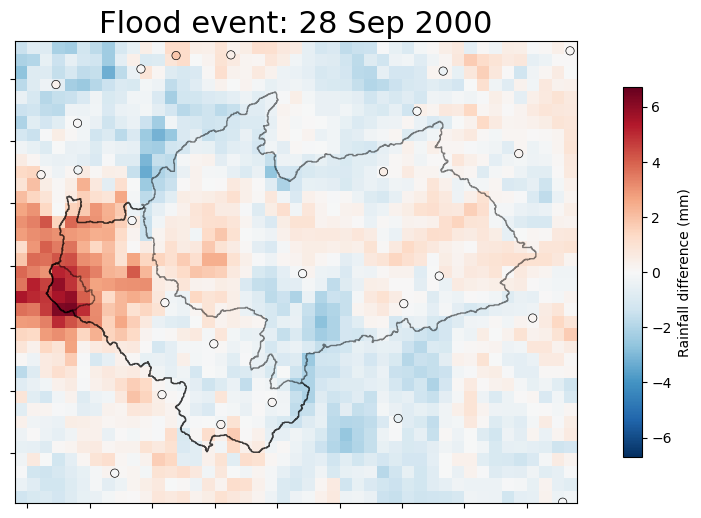

In [31]:
fig, ax = plt.subplots(1, figsize=(12, 6), sharex=True, sharey=True)

rain_vmin = -6.7
rain_vmax = 6.7
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap=used_cmap, vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Rainfall difference (mm)', 'shrink': 0.8})

sns.scatterplot(x='easting', y='northing', hue='mean_diff_rain_mm', data=nearby_gauge_df.round(2),\
        hue_norm=(rain_vmin, rain_vmax), palette='RdBu_r', ax=ax, legend=False, edgecolor='k')
ax.set_xticklabels(''); ax.set_yticklabels('');
ax.set_xlabel(''); ax.set_ylabel('');
abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)

ax.set_title(f'Flood event: {flood_date.strftime('%d %b %Y')}', size=22)
plt.subplots_adjust(hspace=.2)
# fig.savefig(f'../figures/upper_severn_floods/ceh_vs_haduk_grid_vs_gauge_flood_{flood_date.strftime('%d_%b_%Y')}.png', bbox_inches='tight', dpi=200)

## Repeat for all floods

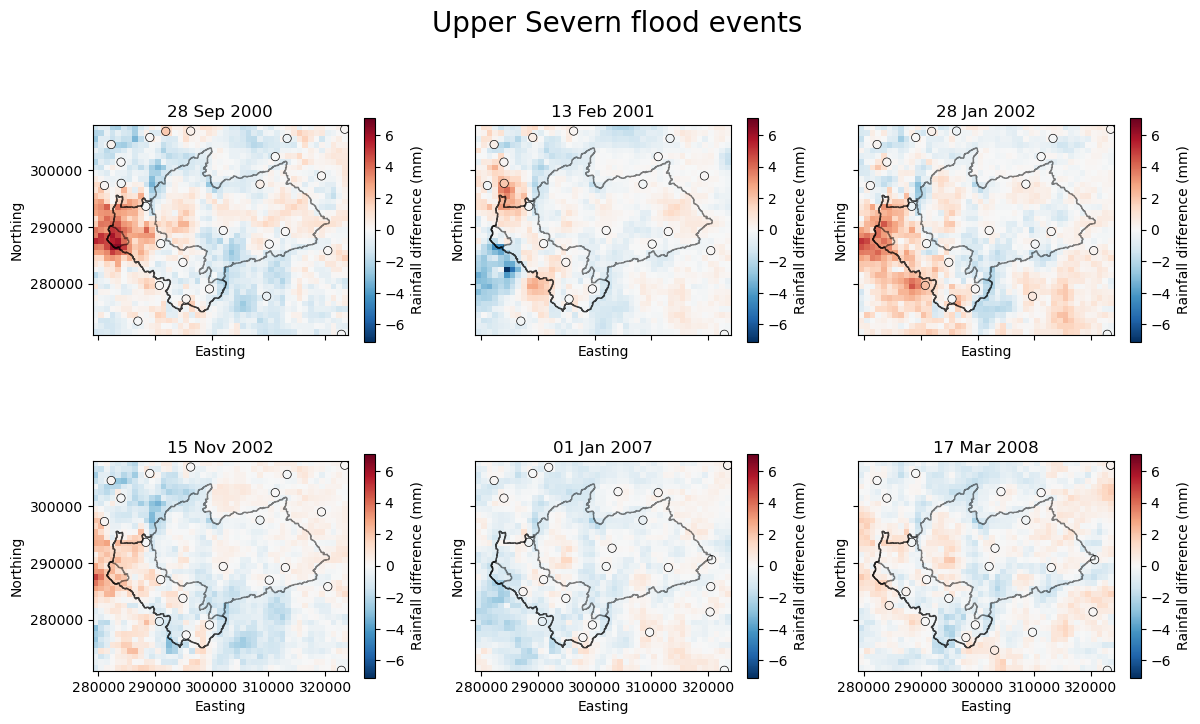

In [32]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)

rain_vmin = -7.1
rain_vmax = 7.1
used_cmap = plt.get_cmap('RdBu_r')
cmap_norm = plt.Normalize(rain_vmin, rain_vmax)

for flood_date, ax in zip(severn_flood_dates, axes.flatten()):
    ## get CEH-GEAR data
    ceh_abermule_for_flood = ceh_abermule.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood[diff_col_name].mean('time')

    ## get nearby gauges rain
    nearby_gauge_dict = {}
    for gauge_id in carreg_gauge_wide_neighbours.nearby_gauges:
        try:
            nearby_gauge = Gauge(gauge_id, nearby_threshold_m=nearby_threshold_m)
            rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
            mean_rain_ndays_before = rain_ndays_before.mean()[f'{RAIN_COL}_gauge'].item()
            assert mean_rain_ndays_before, "No data during flood event"
        except AssertionError:
            continue
        nearby_diff = ceh_abermule_for_flood[RAIN_COL].sel(x=nearby_gauge.gauge_easting, y=nearby_gauge.gauge_northing, method='nearest').load()
        nearby_diff_df = convert_time_to_hour_base(pl.from_dataframe(nearby_diff.to_dataframe().reset_index()), hour=9)
        nearby_diff_df_joined = nearby_diff_df.join(rain_ndays_before, on='time', how='full')
        nearby_gauge_dict[gauge_id] = {}
        nearby_gauge_dict[gauge_id]['easting'] = nearby_gauge.gauge_easting
        nearby_gauge_dict[gauge_id]['northing'] = nearby_gauge.gauge_northing
        rain_ndays_before = get_data_ndays_before_flood_date(nearby_gauge.gauge_data, flood_date, DAYS_BEFORE_FLOOD-1)
        rain_ndays_before = rain_ndays_before.sort(by='time')
        nearby_gauge_dict[gauge_id]['mean_diff_rain_mm'] = (nearby_diff_df_joined['rain_mm'] - nearby_diff_df_joined['rain_mm_gauge']).mean()
    nearby_gauge_df = pd.DataFrame.from_dict(nearby_gauge_dict).T.reset_index(names='gauge_id')

    ## plot data
    ceh_haduk_diff_for_flood_mean.plot(ax=ax, cmap='RdBu_r', vmin=rain_vmin, vmax=rain_vmax, center=0, cbar_kwargs={'label': 'Rainfall difference (mm)', 'shrink': 0.8})

    sns.scatterplot(x='easting', y='northing', hue='mean_diff_rain_mm', data=nearby_gauge_df.round(2),\
            hue_norm=(rain_vmin, rain_vmax), palette='RdBu_r', ax=ax, legend=False, edgecolor='k')
    abermule_shp.plot(ax=ax, facecolor='none', alpha=.5)
    dolwen_shp.plot(ax=ax, facecolor='none', alpha=.5)
    plynlimon_shp.plot(ax=ax, facecolor='none', alpha=.5)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}')
    ax.set_xlabel('Easting'); ax.set_ylabel('Northing');

plt.suptitle("Upper Severn flood events", size=20)
plt.subplots_adjust(wspace=.2)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_events_differences.png', bbox_inches='tight', dpi=200)


# Mask regions

### Functions to mask rainfall to catchments

In [33]:
def make_region_hght_clip(region_shp, hght_data):
    region_clip = hght_data.rio.clip(region_shp.geometry.values, region_shp.crs, drop=False, invert=False)
    return region_clip


def binarize_hght_clip(region_data):
    """
    Make binary mask of clipped region data data
    """
    return (region_data/region_data.where(region_data>0))


In [34]:
def mask_region_rainfall(rainfall_data, region_mask):
    return rainfall_data * binarize_hght_clip(region_mask).data


def mask_region_rainfall_by_hght(rainfall_data, region_hght, threshold):
    region_hght_mask = region_hght/region_hght.where(region_hght > threshold)
    return rainfall_data * region_hght_mask.data



In [35]:
abermule_hght = make_region_hght_clip(abermule_shp, hght_data=severn_hght)
dolwen_hght = make_region_hght_clip(dolwen_shp, hght_data=severn_hght)
plynlimon_hght = make_region_hght_clip(plynlimon_shp, hght_data=severn_hght)


In [36]:
catchments_shp_and_hght = {'Abermule': {'shp': abermule_shp, 'hght': abermule_hght}, \
    'Dolwen': {'shp': dolwen_shp, 'hght': dolwen_hght},\
    'Plynlimon Flume': {'shp': plynlimon_shp, 'hght': plynlimon_hght}}

In [37]:
region_to_examine = 'Abermule'


In [38]:
def get_regline(x, y):
    linreg_coef = np.polyfit(x, y, deg=1)
    linreg_func = np.poly1d(linreg_coef)
    return linreg_func

def plot_scatter_w_regline(x, y, ax, x_pos, y_pos, **kwargs):
    linreg_func = get_regline(x, y)
    rval, pval = scipy.stats.pearsonr(x, y)
    ax.scatter(x, y, **kwargs)
    ax.plot(x, y, 'o', x, linreg_func(x))
    ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos)
    return ax

Text(0.5, 0.98, 'Upper Severn flood events (Abermule only)')

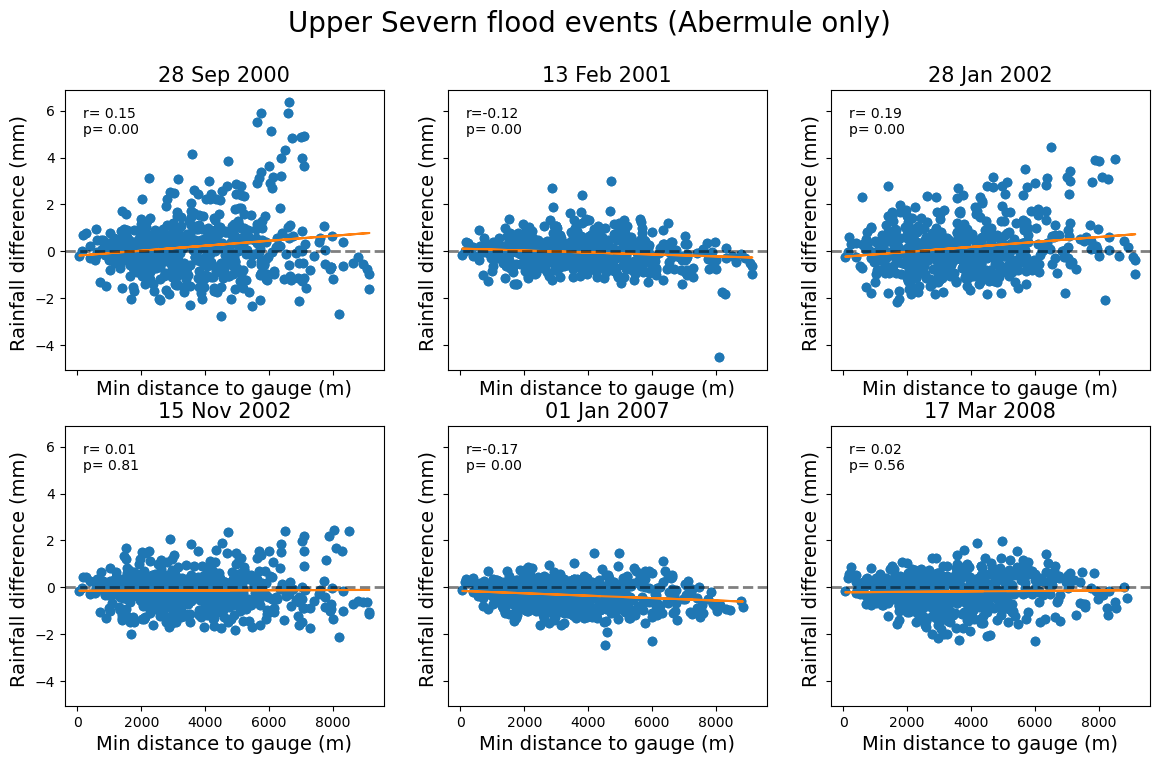

In [39]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)


for flood_date, ax in zip(severn_flood_dates, axes.flatten()):
    ## get CEH-GEAR data
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood.mean('time').load()
    ceh_haduk_diff_for_flood_mean_masked = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght[region_to_examine]['hght'])

    x = ceh_haduk_diff_for_flood_mean_masked['min_dist'].data.flatten()
    y = ceh_haduk_diff_for_flood_mean_masked[diff_col_name].data.flatten()

    ## workaround required when using mask
    x = x[np.isfinite(x)]
    y = y[np.isfinite(y)]

    ## Make plot
    plot_scatter_w_regline(x, y, ax, x_pos=170, y_pos=5)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}', size=15)
    ax.set_xlabel("Min distance to gauge (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm) ", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

plt.suptitle(f"Upper Severn flood events ({region_to_examine} only)", size=20)
# fig.savefig(f'../figures/upper_severn_floods/{region_to_examine}_flood_events_scatter_mindist.png', bbox_inches='tight', dpi=200)

In [40]:
abermule_hght_mask = binarize_hght_clip(abermule_hght)
dolwen_hght_mask = binarize_hght_clip(dolwen_hght)
plynlimon_hght_mask = binarize_hght_clip(plynlimon_hght)

In [41]:
def get_gauges_in_each_region_mask(gauge_data):
    abermule_gauge_inds = []
    dolwen_gauge_inds = []
    plynlimon_gauge_inds = []

    for ind, gauge in gauge_data.iterrows():
        if not np.isnan(plynlimon_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            plynlimon_gauge_inds.append(int(gauge['gauge_id']))
            continue
        if not np.isnan(dolwen_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            dolwen_gauge_inds.append(int(gauge['gauge_id']))
            continue
        if not np.isnan(abermule_hght_mask.sel(x=gauge['easting'], y=gauge['northing'], method='nearest')):
            abermule_gauge_inds.append(int(gauge['gauge_id']))
            continue
    return abermule_gauge_inds, dolwen_gauge_inds, plynlimon_gauge_inds


Text(0.5, 0.98, 'Upper Severn flood events')

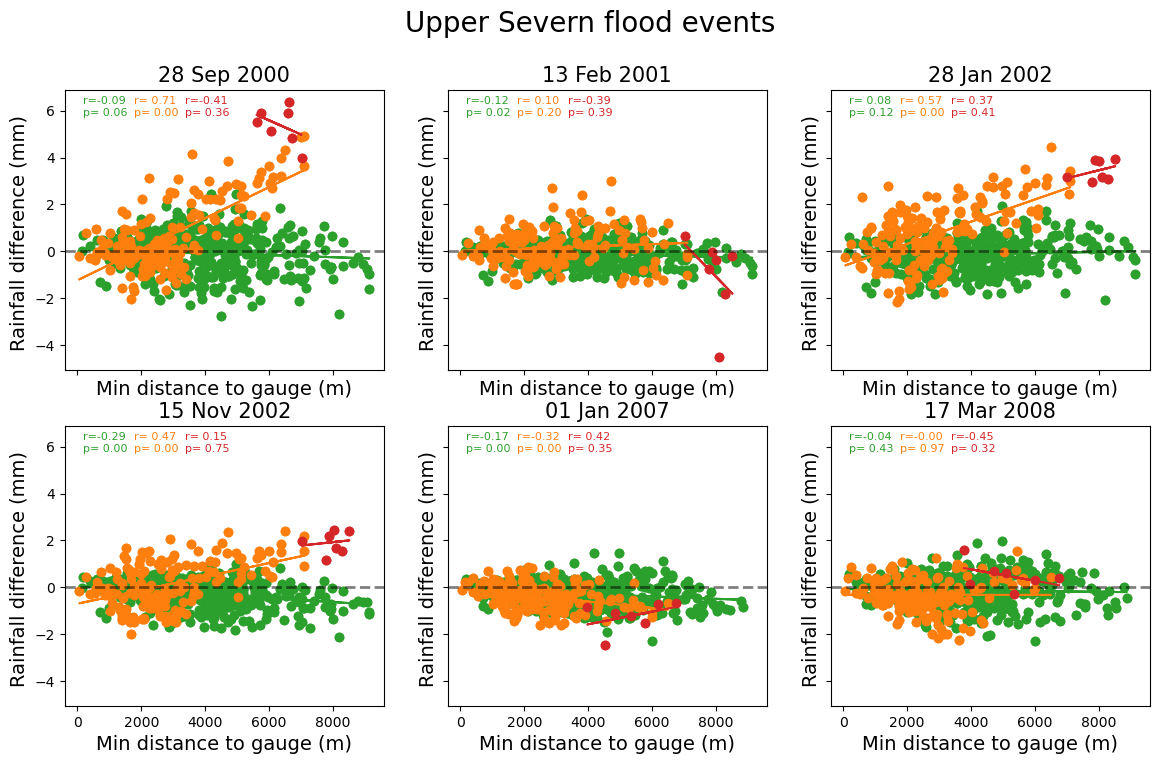

In [42]:
fig, axes = plt.subplots(2, 3, figsize=(14, 8), sharex=True, sharey=True)


for flood_date, ax in zip(severn_flood_dates, axes.flatten()):
    ## get CEH-GEAR data
    ceh_haduk_diff_for_flood = ceh_haduk_diff.sel(time=slice(flood_date-datetime.timedelta(days=DAYS_BEFORE_FLOOD), flood_date))
    ceh_haduk_diff_for_flood_mean = ceh_haduk_diff_for_flood.mean('time').load()
    x_pos, y_pos = 170, 5.8
    for region, color_to_use in zip(catchments_shp_and_hght.keys(), ['C2', 'C1', 'C3']):
        ceh_haduk_diff_for_flood_mean_masked = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght[region]['hght'])

        ## mask out all other regions:
        if region == 'Abermule':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Dolwen']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
        elif region == 'Dolwen':
            other_region_mask = mask_region_rainfall(ceh_haduk_diff_for_flood_mean, catchments_shp_and_hght['Plynlimon Flume']['hght'])
            ceh_haduk_diff_for_flood_mean_masked = ceh_haduk_diff_for_flood_mean_masked.where(other_region_mask['rain_mm_diff'].isnull())
            x_pos += 1600
        else:
            x_pos += 1600
        x = ceh_haduk_diff_for_flood_mean_masked['min_dist'].data.flatten()
        y = ceh_haduk_diff_for_flood_mean_masked[diff_col_name].data.flatten()

        ## workaround required when using mask
        x = x[np.isfinite(x)]
        y = y[np.isfinite(y)]

        ## Make plot
        linreg_func = get_regline(x, y)
        rval, pval = scipy.stats.pearsonr(x, y)
        ax.scatter(x, y, c=color_to_use)
        ax.plot(x, y, 'o', x, linreg_func(x), c=color_to_use)
        ax.text(s=f'r={rval: .2f}\np={pval: .2f}', x=x_pos, y=y_pos, size=8, c=color_to_use)
    ax.set_title(f'{flood_date.strftime('%d %b %Y')}', size=15)
    ax.set_xlabel("Min distance to gauge (m)", size=14)
    ax.set_ylabel("Rainfall difference (mm) ", size=14)
    ax.axhline(0, linestyle='--', linewidth=2, color='k', alpha=.5)

plt.suptitle(f"Upper Severn flood events", size=20)
# fig.savefig(f'../figures/upper_severn_floods/uppersevern_flood_events_scatter_mindist.png', bbox_inches='tight', dpi=200)